## Classification Models

Pipeline for comparing classification models. 

- identifies the top features based on t-test results, with p-value threshold of < 0.10
- merge top features with holdout dataset that splits into train and test data
- run classification models using: Logistic Regression, SVC, Naive Bayes, & KNN (we can include others, just used this as a starting point)
- evaluate & predict with test data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
path = './data files/'

In [4]:
# get datasets

df_audio = pd.read_csv('Teacher_Mindfulness_Audio_Transcript_Features_20230214.csv')
df_survey = pd.read_csv('survey data.csv',
                        usecols = ['studyid', 'mindfulness'])

# merge datasets
df_merged = df_audio.merge(df_survey, 
                    left_on = 'ID', 
                    right_on = 'studyid')

In [5]:
# create a df with only the features + dependent var 

data = df_merged.copy()
data = data.drop(['ID', 'studyid', 'Mood'], axis=1)
data.head()

,Total_Duration,Teacher_Duration,Student_Duration,Percent_Time_Teacher,Average_Speaker_Duration,Average_Teacher_Duration,Average_Student_Duration,Total_Word_Count,Teacher_Word_Count,Student_Word_Count,Teacher_Percent_Words,Total_Word_Rate,Teacher_Word_Rate,Student_Word_Rate,Total_Speaker_Line_Count,Teacher_Line_Count,Student_Line_Count,number_ of_syllables,number_of_pauses,rate_of_speech,articulation_rate,speaking_duration,original_duration,balance,f0_mean,f0_std,f0_median,f0_min,f0_max,f0_quantile25,f0_quan75,MFCC_1_Mean,MFCC_2_Mean,MFCC_3_Mean,MFCC_4_Mean,MFCC_5_Mean,MFCC_6_Mean,MFCC_7_Mean,MFCC_8_Mean,MFCC_9_Mean,MFCC_10_Mean,MFCC_11_Mean,MFCC_12_Mean,MFCC_13_Mean,MFCC_1_Var,MFCC_2_Var,MFCC_3_Var,MFCC_4_Var,MFCC_5_Var,MFCC_6_Var,MFCC_7_Var,MFCC_8_Var,MFCC_9_Var,MFCC_10_Var,MFCC_11_Var,MFCC_12_Var,MFCC_13_Var,MFCC_1_Skew,MFCC_2_Skew,MFCC_3_Skew,MFCC_4_Skew,MFCC_5_Skew,MFCC_6_Skew,MFCC_7_Skew,MFCC_8_Skew,MFCC_9_Skew,MFCC_10_Skew,MFCC_11_Skew,MFCC_12_Skew,MFCC_13_Skew,MFCC_1_Kurtosis,MFCC_2_Kurtosis,MFCC_3_Kurtosis,MFCC_4_Kurtosis,MFCC_5_Kurtosis,MFCC_6_Kurtosis,MFCC_7_Kurtosis,MFCC_8_Kurtosis,MFCC_9_Kurtosis,MFCC_10_Kurtosis,MFCC_11_Kurtosis,MFCC_12_Kurtosis,MFCC_13_Kurtosis,RMS_Mean,RMS_Max,RMS_Min,RMS_Std,Centroid_Mean,Centroid_Max,Centroid_Min,Centroid_Std,Bandwidth_Mean,Bandwidth_Max,Bandwidth_Min,Bandwidth_Std,Flatness_Mean,Flatness_Max,Flatness_Min,Flatness_Std,Zero_Crossing_Rate_Mean,Zero_Crossing_Rate_Max,Zero_Crossing_Rate_Min,Zero_Crossing_Rate_Std,Loudness_Mean,Loudness_Max,Loudness_Min,Loudness_Std,mindfulness
0,308.563991,141,167.563991,0.456955,9.075411,8.294118,9.856705,697,305,392,0.437590,2.258851,2.163121,2.339405,34,17,17,411,62,3.0,4,93.5,144.6,0.6,211.67,53.96,204.2,73,409,181,242,12.275767,11.248416,-11.403405,8.994111,-6.947085,3.552934,-2.149697,-13.171859,-11.721801,-13.183566,0.719455,-1.359205,2.892683,59.003330,428.052921,376.570811,480.629189,271.816805,240.442430,250.107968,218.737862,230.139384,183.706385,173.748565,163.662589,96.546882,-4.427178,-0.384546,-0.256914,0.305199,-0.266844,-0.182173,-0.167009,-0.289583,-0.229382,-0.212150,0.169246,0.047610,0.078353,24.993674,-1.021163,-0.388692,-0.197681,-0.027963,0.335898,0.345799,0.218810,0.077423,0.002506,0.748178,0.050016,0.413932,0.029641,0.234953,0.0,0.030134,1786.920458,9837.121455,0.0,1342.793978,1637.887678,4029.576143,0.0,736.167078,0.019112,1.000001,1.480000e-06,0.101342,0.106655,0.724121,0.0,0.111820,-41.060013,-12.580391,-92.580391,19.036415,1
1,309.289320,86,223.289320,0.278057,6.580624,3.739130,9.303722,698,195,503,0.279370,2.256787,2.267442,2.252683,47,23,24,255,39,3.0,5,50.5,86.0,0.6,244.32,56.67,242.1,80,421,208,278,10.869401,9.074677,-11.908164,7.795241,-7.867180,-0.395680,-6.808521,-14.854105,-5.608134,0.335741,2.010402,-11.104792,-2.374372,117.844373,443.504212,340.872066,421.846288,392.088738,269.676208,282.780823,278.891346,201.598711,184.257387,180.524235,156.742620,103.860091,-3.403572,-0.447509,-0.170911,0.054505,-0.355915,0.015943,-0.269408,-0.323910,-0.181812,0.243745,0.255444,-0.148239,-0.153220,12.028351,-0.977772,-0.562810,-0.102892,-0.054601,0.898272,0.406222,-0.280488,0.297556,0.332433,0.374174,-0.063299,0.823779,0.027384,0.194261,0.0,0.029680,1880.643307,9922.177642,0.0,1412.091525,1741.747397,4338.004791,0.0,810.380525,0.038517,1.000001,2.170000e-06,0.168635,0.102524,0.819824,0.0,0.115759,-43.753429,-14.232292,-94.232292,21.297735,1
2,313.918662,145,168.918662,0.461903,6.975970,6.590909,7.344290,1021,567,454,0.555338,3.252435,3.910345,2.687684,45,22,23,427,87,3.0,5,87.3,141.0,0.6,239.45,66.01,232.6,72,424,189,287,11.718530,5.376386,-16.785159,14.851442,-1.599988,0.735789,-0.782310,-13.534004,-5.126506,-5.123688,-7.457674,-6.685852,-0.191224,103.212547,407.618625,404.010201,325.159615,254.870539,195.726934,270.849372,262.024990,174.123677,163.250007,181.294042,127.413792,87.696152,-3.331619,-0.295017,-0.139161,0.311863,-0.106684,-0.227299,-0.159920,-0.256241,-0.193413,-0.270465,-0.238296,-0.111221,-0.019337,13.087553

In [6]:
# encode the mindfulness variable 

label_encoder = LabelEncoder()
data.iloc[:,-1] = label_encoder.fit_transform(data.iloc[:,-1]).astype('float64')

### Full T-test

In [7]:
# Get list of all potential features in this data
feature_list = [feat for feat in data.columns if feat not in ['mindfulness']]

In [8]:
# Create empty df to hold t-test results
ttest_results = pd.DataFrame()

In [9]:
for feat in feature_list:
    # Separate treatment and control into separate dataframes
    # and select just this feature
    df_0 = data[data['mindfulness']==0]
    df_1 = data[data['mindfulness']==1]
    
    # Compute t test results for this feature
    temp_result = stats.ttest_ind(a = df_0[feat], 
                                  b = df_1[feat],
                                  equal_var = False)
    
    # Add t stat and p value to results df
    df_temp = pd.DataFrame({
                            'feature': feat,
                            'mean_0': df_0[feat].mean(),
                            'mean_1': df_1[feat].mean(),
                            't_statistic': temp_result[0],
                            'p_value': temp_result[1]
                            }, 
                            index = [0])
    
    ttest_results = pd.concat([ttest_results, df_temp], axis=0)

In [10]:
ttest_results.reset_index(inplace = True, drop = True)

In [11]:
# Sort by p-value to see which variables show the largest differences
ttest_results.sort_values('p_value', inplace = True)
ttest_results.head(10)

,feature,mean_0,mean_1,t_statistic,p_value
5,Average_Teacher_Duration,8.770774,7.721627,2.285240,0.024762
9,Student_Word_Count,264.717391,292.534884,-1.840621,0.069809
67,MFCC_11_Skew,0.051254,-0.028348,1.818815,0.072385
102,Zero_Crossing_Rate_Std,0.105381,0.097978,1.703519,0.092466
72,MFCC_3_Kurtosis,-0.375162,-0.504436,1.702287,0.092631
15,Teacher_Line_Count,22.130435,23.651163,-1.683496,0.095866
77,MFCC_8_Kurtosis,0.067956,-0.076068,1.600801,0.114777
13,Student_Word_Rate,2.085660,2.200172,-1.583698,0.116980
101,Zero_Crossing_Rate_Min,0.000053,0.000488,-1.547210,0.128802
76,MFCC_7_Kurtosis,0.343888,0.032315,1.508744,0.136756


In [12]:
# only the features that have a p-value < 0.10

top_feats = ttest_results.head(6).feature.to_list()

In [13]:
top_feats

['Average_Teacher_Duration',
 'Student_Word_Count',
 'MFCC_11_Skew',
 'Zero_Crossing_Rate_Std',
 'MFCC_3_Kurtosis',
 'Teacher_Line_Count']

#### Merge w/ Holdout Data

In [14]:
# adds ID variable back in with only the top features to be merged with the holdout data

df_features = df_merged[['ID', 'Average_Teacher_Duration', 'Student_Word_Count', 'MFCC_11_Skew', 'Zero_Crossing_Rate_Std', 'MFCC_3_Kurtosis', 'Teacher_Line_Count']]
df_features.head()

,ID,Average_Teacher_Duration,Student_Word_Count,MFCC_11_Skew,Zero_Crossing_Rate_Std,MFCC_3_Kurtosis,Teacher_Line_Count
0,332,8.294118,392,0.169246,0.111820,-0.388692,17
1,348,3.739130,503,0.255444,0.115759,-0.562810,23
2,335,6.590909,454,-0.238296,0.102428,-0.742316,22
3,320,6.923077,244,0.197057,0.117673,-0.472633,26
4,328,9.619048,219,0.086985,0.098971,-0.367721,21


In [15]:
# get holdout data

url = 'https://raw.githubusercontent.com/eycooper/capstone/main/holdout_samples_lookup.csv'
df_holdout_lookup = pd.read_csv(url)

In [16]:
df = df_features.merge(df_holdout_lookup,
                          left_on = 'ID', 
                          right_on = 'studyid')
df.drop(['studyid', '300s'], axis = 1, inplace = True)

In [17]:
df.head()

,ID,Average_Teacher_Duration,Student_Word_Count,MFCC_11_Skew,Zero_Crossing_Rate_Std,MFCC_3_Kurtosis,Teacher_Line_Count,mindfulness,holdout
0,332,8.294118,392,0.169246,0.111820,-0.388692,17,1,0
1,348,3.739130,503,0.255444,0.115759,-0.562810,23,1,0
2,335,6.590909,454,-0.238296,0.102428,-0.742316,22,1,1
3,320,6.923077,244,0.197057,0.117673,-0.472633,26,1,0
4,328,9.619048,219,0.086985,0.098971,-0.367721,21,0,1


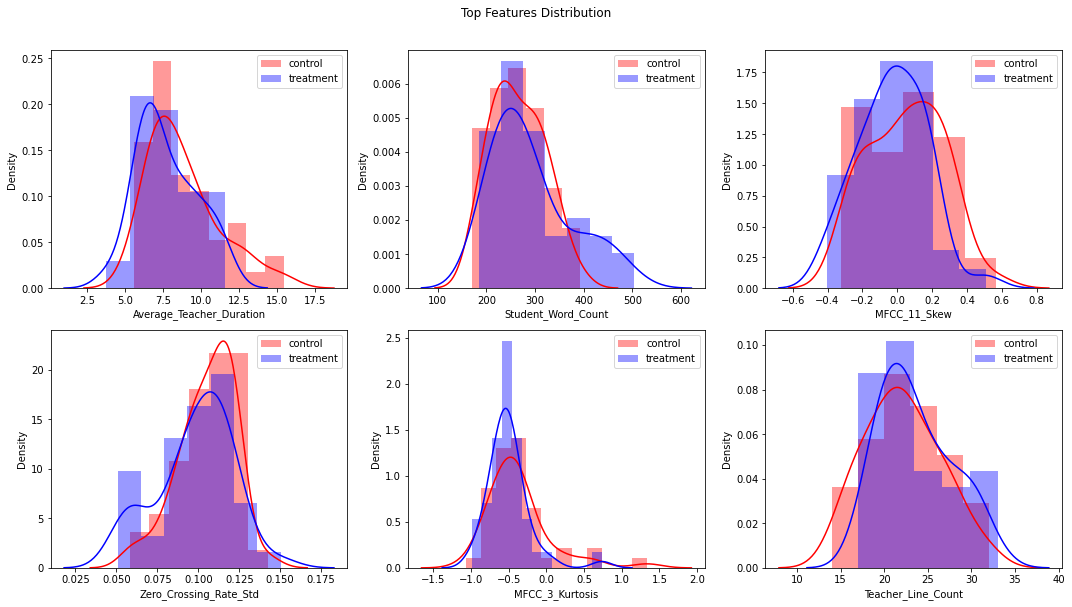

In [18]:
fig = plt.figure(figsize = (15, 20))
j = 0
for i in top_feats:
    plt.subplot(5, 3, j+1)
    j += 1
    sns.distplot(df[i][df['mindfulness']==0], color='red', label = 'control')
    sns.distplot(df[i][df['mindfulness']==1], color='blue', label = 'treatment')
    plt.legend(loc='best')
fig.suptitle('Top Features Distribution')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

#### Model Comparison

In [19]:
df['holdout'].value_counts()

0    71
1    18
Name: holdout, dtype: int64

In [20]:
# feature vectors & target variable

X_train = df[df['holdout']==0].drop(['mindfulness', 'ID', 'holdout'], axis=1)
y_train = df[df['holdout']==0]['mindfulness']

X_test = df[df['holdout']==1].drop(['mindfulness', 'ID', 'holdout'], axis=1)
y_test = df[df['holdout']==1]['mindfulness']

In [21]:
# check that split is correct 

check = [X_train.shape[0], y_train.shape[0], X_test.shape[0], y_test.shape[0]]
check

[71, 71, 18, 18]

In [22]:
# import sklearn modules 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [23]:
# compare models 
models = []

def classification_models(X_train, X_test, y_train, y_test):
    
    models.append(('Logistic Regression', LogisticRegression() ))
    models.append( ('SVM',  SVC()) )
    models.append( ('Naive Bayes',  GaussianNB()) )
    models.append( ('KNN', KNeighborsClassifier()) )
    
    model_outcomes = []
    model_names = []
    
    for name, model in models:
        results = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        
        model_outcomes.append(results)
        model_names.append(name)
        
        print(name, results.mean())
        
    #print(model_outcomes)       
    

In [24]:
# training accuracy for each model

classification_models(X_train, X_test, y_train, y_test)

Logistic Regression 0.5647619047619047
SVM 0.6066666666666667
Naive Bayes 0.6504761904761904
KNN 0.5057142857142856


In [25]:
# evaluation & prediction

for name, model in models:
    trainedmodel = model.fit(X_train,y_train)
    
    # prediction
    ypredict = trainedmodel.predict(X_test)
    
    acc = accuracy_score(y_test,ypredict)
    classreport = classification_report(y_test,ypredict)
    confMat = confusion_matrix(y_test,ypredict)
    
    print('Model Type: {}'.format(name))
    
    print('The accuracy: {}'.format(acc))
    print('The Classification Report:\n {}'.format(classreport))
    print('The Confusion Matrix:\n {}'.format(confMat))
    print('\n************')

Model Type: Logistic Regression
The accuracy: 0.6111111111111112
The Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59         9
           1       0.60      0.67      0.63         9

    accuracy                           0.61        18
   macro avg       0.61      0.61      0.61        18
weighted avg       0.61      0.61      0.61        18

The Confusion Matrix:
 [[5 4]
 [3 6]]

************
Model Type: SVM
The accuracy: 0.5555555555555556
The Classification Report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69         9
           1       1.00      0.11      0.20         9

    accuracy                           0.56        18
   macro avg       0.76      0.56      0.45        18
weighted avg       0.76      0.56      0.45        18

The Confusion Matrix:
 [[9 0]
 [8 1]]

************
Model Type: Naive Bayes
The accuracy: 0.6666666666666666
The Classificat

#### Observations



### Correlation

I wanted to see if the features would be different if we ran correlations first

In [26]:
corr = data.corr()

In [27]:
# removing features that are highly correlated (above 0.8)

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False

In [28]:
# reduced to 70 features

selected_columns = data.columns[columns]
selected_columns.shape

(70,)

In [29]:
data2 = data[selected_columns]
# data2.info()

#### T-test using only the selected columns (not highly correlated)

In [30]:
# Get list of all potential features in this data
feature_list2 = [feat for feat in data2.columns if feat not in ['mindfulness']]

In [31]:
# Create empty df to hold t-test results
ttest_results2 = pd.DataFrame()

In [32]:
for feat in feature_list2:
    # Separate treatment and control into separate dataframes
    # and select just this feature
    df_0 = data2[data2['mindfulness']==0]
    df_1 = data2[data2['mindfulness']==1]
    
    # Compute t test results for this feature
    temp_result = stats.ttest_ind(a = df_0[feat], 
                                  b = df_1[feat],
                                  equal_var = False)
    
    # Add t stat and p value to results df
    df_temp = pd.DataFrame({
                            'feature': feat,
                            'mean_0': df_0[feat].mean(),
                            'mean_1': df_1[feat].mean(),
                            't_statistic': temp_result[0],
                            'p_value': temp_result[1]
                            }, 
                            index = [0])
    
    ttest_results2 = pd.concat([ttest_results2, df_temp], axis=0)

In [33]:
ttest_results2.reset_index(inplace = True, drop = True)

In [34]:
# Sort by p-value to see which variables show the largest differences
ttest_results2.sort_values('p_value', inplace = True)
ttest_results2.head(10)

,feature,mean_0,mean_1,t_statistic,p_value
4,Average_Teacher_Duration,8.770774,7.721627,2.285240,0.024762
7,Student_Word_Count,264.717391,292.534884,-1.840621,0.069809
52,MFCC_11_Skew,0.051254,-0.028348,1.818815,0.072385
57,MFCC_3_Kurtosis,-0.375162,-0.504436,1.702287,0.092631
8,Student_Word_Rate,2.085660,2.200172,-1.583698,0.116980
68,Zero_Crossing_Rate_Min,0.000053,0.000488,-1.547210,0.128802
53,MFCC_12_Skew,-0.071631,-0.008063,-1.464119,0.146775
3,Average_Speaker_Duration,7.012421,6.618816,1.456309,0.149022
59,MFCC_9_Kurtosis,0.280607,0.168745,1.445187,0.152699
30,MFCC_12_Mean,-5.477647,-4.137505,-1.306964,0.194720
